<h1> Case de Estudo - Risco de Crédito <h1>

<h2> O que é o Risco de Crédito ? </h2>

**Risco de Crédito** é a possibilidade de ocorrência de perdas financeiras devido ao não cumprimento das obrigações por parte do tomador. Em outras palavras, é o risco de inadimplência por parte do tomador do crédito. 


<h2> Como o Risco de Crédito funciona? </h2>

Suponhamos que uma pessoa visite uma loja de móveis e eletrodomésticos com o objetivo de comprar uma televisão nova. Lá, ela escolhe o modelo de sua preferência e, ao se dirigir ao caixa, opta pelo pagamento a prazo. O funcionário da loja, então, emite um carnê em nome do cliente, que se compromete a quitar a dívida em até 12 meses. Por fim, o mesmo deixa a loja radiante, levando consigo a tão sonhada televisão.Agora pense um pouco e responda: como a empresa pode ter tanta certeza de que, após entregar o produto ao consumidor, ele realizará mesmo o pagamento?

A resposta é: ela não tem!

E é justamente a essa impossibilidade de garantir um recebimento que se dá o nome de risco de crédito.

Para empresas e investidores, é impossível ignorá-lo.

<h2> Como é feita a classificação dos riscos de crédito ? </h2>

No geral, os riscos de crédito são classificados entre riscos de primeira classe e riscos de segunda classe. Os riscos de primeira classe dizem respeito a operações de crédito com alta chance de inadimplência. Por conta disso, exigem um volume maior de garantias para proteger o credor. Já os riscos de segunda classe estão relacionados a operações de risco menor. Em geral, o bem objeto da transação pode ser revisto em caso de não-pagamento, o que garante que o credor possa comercializá-lo novamente para cobrir parte da dívida.

<h2> Quais são as principais táticas utilizadas para minimizar o risco de crédito? </h2>

 - Estudo dos dados do cliente, assim como da sua situação socioeconômica, é tomada a decisão de conceder ou não o crédito solicitado. Em tese, a análise de crédito deve ser composta por processos muito rigorosos, de modo a proteger a saúde financeira da organização e prevenir prejuízos - mesmo que isso signifique vetar algumas vendas.

- Diversificação de investimentos e a checagem do rating de cada organização com potencial para compor a sua carteira.


<h2> Apresentando os Dados </h2>
    
Este projeto estará utilizando o conjunto de dados de um banco alemão que pode ser encontrado nesse [site](https://www.kaggle.com/kabure/german-credit-data-with-risk).
    
    
 <h2> Objetivo do Estudo de Caso </h2>
    
Criar um modelo de **Machine Learning** capaz de fazer a previsão de risco de crédito de clientes de um banco através da análise de dados.  

# 0.0 Introdução

## 0.1 Bibliotecas

In [1]:
import inflection
import pandas            as pd
import numpy             as np
import json
import requests
import warnings

import matplotlib.pyplot as plt
import pickle            as pi
import seaborn           as sns
import sweetviz          as sw

from  flask                               import Flask, request, Response
from  IPython.core.display                import HTML
from  IPython.display                     import Image

# Preprocessamento         
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

# Modelos de Machine Learning

from sklearn.tree            import DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier

# Métricas de Avaliação
from sklearn.metrics         import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics         import confusion_matrix

warnings.filterwarnings('ignore')

## 0.2 Funções Auxiliares

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Função Verificação de Outliers
def outliers(dataset,var):
    
    figure, gr = plt.subplots()
    
    gr.figure.set_size_inches(14,12)
    
    plt.subplot(2,1,1)
    gr = sns.distplot(dataset[var], bins=50)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Densidade', fontsize=14)
    plt.subplots_adjust(hspace=0.3)
    plt.subplot(2,1,2)
    gr = sns.boxplot(dataset[var])
    plt.xlabel(var, fontsize=14)
    plt.show()
    
    # Calculando Q1, Q3 and FIQ
    Q1 = np.quantile(dataset[var], 0.25)
    Q3 = np.quantile(dataset[var], 0.75)
    FIQ = Q3 - Q1
    
    # Calculando o limite dos outliers
    min_outliers = Q1 - 1.5 * FIQ
    max_outliers = Q3 + 1.5 * FIQ
    
    print('Limites para outliers:')
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nFIQ = {FIQ}\nmin_outliers = {min_outliers}\nmax_outliers = {max_outliers}")
    
    
# Função Validação Cruzada    
def validacao_cruzada(x,y,classificadores, nomes_classificadores):
    
    resultados = {}
    
    for i in range(len(classificadores)):
        accs_vc = cross_validate(classificadores[i], x, y, cv=StratifiedKFold(n_splits=10),
                                scoring=['accuracy', 'precision','recall','f1'])
                   
        acc = accs_vc['test_accuracy'].mean()
        prec = accs_vc['test_precision'].mean()
        sens = accs_vc['test_recall'].mean()
        f1 = accs_vc['test_f1'].mean()
    
        resultados[nomes_classificadores[i]] = [acc, prec, sens, f1]
        
    resultados = pd.DataFrame(resultados, index=['Acurácia', 'Precisão', 'Sensibilidade', 'F1-Score'])
    
    return resultados


# Função Machine Learning com Validação Cruzada - Dados de Treinamento
def machine_learning(classificadores, nomes_classificadores,x_treino, y_treino):
    
    for clf in classificadores:
        print('Treinando ' + type(clf).__name__ + "...")
        # Treinando Classificador
        clf.fit(x_treino,y_treino)
        
        performance = validacao_cruzada(x_treino, y_treino, classificadores, nomes_classificadores)
        
    return performance.T


# Funções Matrizes de Confusão
def matrizes_de_confusao(modelos, x_treino, y_treino,linhas, colunas, a,b):
    
    # definindo Plots
    fig, ax = plt.subplots(nrows=linhas, ncols=colunas, figsize=(a,b))
    
    for mod, ax, n in zip(range(len(modelos)),ax.flatten(), list(range(linhas*colunas))):
        
        plt.subplot(linhas, colunas, n+1)
        
        predicoes = cross_val_predict(modelos[mod], x_treino, y_treino, cv=StratifiedKFold(n_splits=10))
    
        cm = confusion_matrix(y_treino,predicoes)
    
        ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis',
                     square=True, annot_kws={"size": 14})

        plt.xlabel("Valor Predito")
        plt.ylabel("Valor Real")
        ax.title.set_text(type(modelos[mod]).__name__)
        
    plt.tight_layout()
    
    plt.show()
    

# Função de Hipertunagem    
def hipertunagem(modelo,treino,target,parametros,tipo = 'grid',n_iter=20):
    
    validacao = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    if tipo == 'grid':
        search = GridSearchCV(modelo, param_grid=parametros,
                             scoring='f1', cv = validacao,
                             verbose=1, n_jobs=-1)
    elif tipo == 'random':
        search = RandomizedSearchCV(modelo, param_distributions=parametros,
                             scoring= 'f1', cv = validacao,
                                   n_iter=n_iter, verbose=1, n_jobs=-1)
    else:
        print('Entrada invalida no argumento "tipo"')
        
        
        
    search.fit(treino, target)
    
    estimadores = search.best_estimator_
    
    print('\nF1-Score: {:.4f}'.format(search.best_score_))
    
    print('Melhores parâmetros: {}\n'.format(search.best_params_))
    
    return estimadores


# Função Preparação dos dados
def preparacao_dados(dados):
    
    colunas_velhas = dados.columns
    
    snakecase = lambda x: inflection.underscore(x)
    
    colunas_novas = list(map(snakecase, colunas_velhas))
    
    dados.columns = colunas_novas
    
    dados = dados.drop(['unnamed: 0', 'unnamed: 0.1'], axis=1)
    
    dados['job'] = dados['job'].astype('str')
    
    dados['risk'] = dados['risk'].apply(lambda x: 1 if x=='good' else 0)
    
    # Featuring Engineering
    intervalo = (18, 25, 35, 60, 120)
    cats = ['Student', 'Young', 'Adult', 'Senior']
    dados['age_cat'] = pd.cut(dados.age, intervalo, labels=cats)
    
    dados['saving accounts'] = dados.groupby(['sex', 'risk', 'age_cat'])['saving accounts'].transform(
    lambda x: x.fillna(x.mode()[0]))
    
    dados['checking account'] = dados.groupby(['sex', 'risk', 'age_cat'])['checking account'].transform(
    lambda x: x.fillna(x.mode()[0]))
 
    dados['year'] = str(dados["duration"])
    dados.loc[dados["duration"] <= 24, "year"] = "0-2"
    dados.loc[(dados["duration"] > 24) & (dados["duration"] <= 48), "year"] = "2-4"
    dados.loc[(dados["duration"] > 48) & (dados["duration"] <= 72), "year"] = "4-6"
    #dados.loc[(dados["duration"] > 36) & (dados["duration"] <= 48), "year"] = "3-4"
    #dados.loc[(dados["duration"] > 48) & (dados["duration"] <= 60), "year"] = "4-5"
    #dados.loc[(dados["duration"] > 60) & (dados["duration"] <= 72), "year"] = "5-6"
    #dados.loc[(dados["duration"] > 72) & (dados["duration"] <= 84), "year"] = "6-7"
    
    dados['status'] = pd.qcut(dados['credit amount'],4, labels=['poor', 'mid', 'upper', 'rich'])
    
    dados = dados.drop(['duration'], axis=1)
    
    # Robust Scaler
    dados['age'] = rs.fit_transform(dados[['age']].values)
    dados['credit amount'] = rs.fit_transform(dados[['credit amount']].values)
    
    # Dumificação
    dados['purpose'] = dados['purpose'].apply(lambda x: 'car' if x=='car'
                                      else 'radio/TV' if x=='radio/TV'
                                      else 'furniture/equipment' if x=='furniture/equipment'
                                      else 'others')
    
    variaveis_categoricas = ['sex','job', 'housing', 'saving accounts', 'checking account',
                             'purpose','age_cat','year', 'status']
    
    dados = pd.get_dummies(dados, columns=variaveis_categoricas, drop_first=True)
    
    
    return dados 


# Função Performance Dados de Teste
def performance_dados_teste(x_treino,y_treino, x_teste, y_teste, modelo, nome_modelo):
    # Treinando Modelo
    modelo.fit(x_treino, y_treino)
    
    # Previsões do Modelo
    y_hat = modelo.predict(x_teste)
    
    # Métricas de Performance
    acuracia = accuracy_score(y_teste, y_hat)
    precisao = precision_score(y_teste, y_hat)
    sensibilidade = recall_score(y_teste, y_hat)
    f1 = f1_score(y_teste, y_hat)
    
    
    # DataFrame Das Métricas de Performance
    df_performance = pd.DataFrame({'Acurácia': acuracia,
                                   'Precisão': precisao,
                                   'Sensibilidade': sensibilidade,
                                   'F1-Score': f1}, index=[nome_modelo])
    # Matriz de Confusão
    cm = confusion_matrix(y_teste, y_hat)
    
    # Mapa de Calor da Matriz de Confusão
    df_cm = pd.DataFrame(cm)
    
    return df_performance, df_cm

## 0.3 Dicionário de Dados

Antes de começar qualquer etapa do projeto, irei disponibilizar o dicionário de dados que explica o que cada variável significa:

- **Age:** Idade.

- **Sex:** Gênero.

- **Job:** Emprego - 0 - não qualificados e não residentes, 1 - não qualificados e residentes, 2 - qualificados, 3 - altamente qualificados.

- **Housing:** (text: own, rent, or free) - (própria, alugado ou gratuito).

- **Saving Account:** Conta poupança (text - little, moderate, quite rich, rich).

- **Checking Account:** Conta corrente.

- **Credit Amount:** Montante de Crédito.

- **Duration:** Duração de tempo, em meses, dos clientes.

- **Purpose:** Objetivo do Crédito (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others).

- **Risk:** Risco de Crédito se é bom ou ruim.


## 0.4 Carregando Dados

Agora, irei carregar o conjunto de dados que utilizarei na construção do projeto conforme abaixo.

### 0.4.1 Carregando Dados Originais

In [3]:
df = pd.read_csv('/home/nickolas/Área de Trabalho/Portfólio/pa005/data/german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


Pode-se verificar acima que o conjunto de dados total, porém, antes de qualquer análise e tratamento dos dados, irei separar os dados em conjunto de treino e teste. 

### 0.4.2 Separando Dados em Treino e Teste

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


**Observação:**

- O conjunto de dados tem 1000 clientes com 11 características (colunas)
- Memória usada: 86.1 KB
- Existem dados faltantes nas características: `Saving accounts` e `Checking account`

Irei verificar a proporção da variável target `Risk`, pois é necessário fazer uma amostra estratificada nos conjuntos de dados de treino e teste.

In [5]:
# Verificando proporção da variável target
df['Risk'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

In [6]:
# Aplicando Amostra estatificada de acordo com a variável target em conjunto de treino e teste
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df, df['Risk']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]
    

In [7]:
# Verificando proporção na variável target no conjunto de treino
train_set['Risk'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

In [8]:
# Verificando proporção na variável target no conjunto de teste
test_set['Risk'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

### 0.4.3 Salvando Conjuntos de Dados 

In [9]:
# Conjunto de Dados de Treino
train_set.to_csv('/home/nickolas/Área de Trabalho/Portfólio/pa005/data/treino.csv')

# Conjunto de Dados de Teste
test_set.to_csv('/home/nickolas/Área de Trabalho/Portfólio/pa005/data/teste.csv')

# 1.0 Descrição dos Dados

Para dar início ao projeto, nesse módulo que chamo de **Descrição dos Dados**, irei fazer as seguintes etapas:

- Renomeando Colunas
- Dimensão dos Dados
- Tipos de Dados
- Mudança de Dados
- Identificação Dados Faltantes
- Estatística Descritiva

In [10]:
# Carregando Dados de Treino
df1 = pd.read_csv('/home/nickolas/Área de Trabalho/Portfólio/pa005/data/treino.csv')

## 1.1 Renomeando Colunas

Começo o tratamento dos dados renomeando as colunas do conjunto de dados para facilitar as manipulações ao longo do projeto, onde transformarei todas as variáveis que inicia com letra Maiuscula em letra minuscula.

In [11]:
# Listando colunas 
colunas_velhas = ['Unnamed: 0', 'Unnamed: 0.1', 'Age', 'Sex', 'Job', 'Housing',
       'Saving accounts', 'Checking account', 'Credit amount', 'Duration',
       'Purpose', 'Risk']

snakecase = lambda x: inflection.underscore(x)

colunas_novas = list(map(snakecase, colunas_velhas))

df1.columns = colunas_novas

# Excluindo colunas 
df1 = df1.drop(['unnamed: 0', 'unnamed: 0.1'], axis=1) 

## 1.2 Dimensão dos Dados

Nessa etapa, descobrirei qual é o número de linhas e colunas dos dados para saber o tamanho do conjunto de treino. 

In [12]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 700
Número de Colunas: 10


**Observação:**

- O conjunto de treino do banco possui 700 clientes com 10 carateristicas que determinam se cada um tem um risco de crédito bom ou ruim.

- Pode observar que a amostra dos é pequena, sendo que não é necessário a utilização de uma cloud para este projeto.

- Talvez pela quantidade de dados apresentada, os resultados dos modelos podem sair um pouco abaixo do que espero obter.

## 1.3 Tipos de Dados

O próximo passo a considerar são os tipos de dados que estou tratando, pois é de fundamental importância saber o aspecto de cada variável.

In [13]:
df1.dtypes

age                  int64
sex                 object
job                  int64
housing             object
saving accounts     object
checking account    object
credit amount        int64
duration             int64
purpose             object
risk                object
dtype: object

**Observação:**

- Todas as variáveis estão de acordo com o seu tipo, exceto a variável `job` que está como int64, precisa ser transformada em object por ser uma **variável categórica**, conforme o **dicionário de dados**.

## 1.4 Mudança de Dados

- Fazendo a mudança do dado `job` para variável categórica.

In [14]:
df1['job'] = df1['job'].astype('str')

## 1.5 Identificação Dados Faltantes

Identificar os dados faltantes é de extrema importância para que o modelo seja construído de forma saúdavel e assertível. Logo, deve-se preencher todos os NAN do conjunto de dados para não atrapalhar nesses requisitos e na própria análise de dados. Geralmente para o preenchimento desses dados são utilizadas algumas técnicas como a **média, a mediana ou até mesmo alguma solução pensando na questão de negócio**. Portanto, identificarei quais variáveis estão dados faltantes.

In [15]:
df1.isnull().sum()

age                   0
sex                   0
job                   0
housing               0
saving accounts     125
checking account    274
credit amount         0
duration              0
purpose               0
risk                  0
dtype: int64

**Observações:**

- As variável `saving accounts` possui 125 dados faltantes 
- A variável `checking account`possui 274 dados faltantes.

Realizarei o tratamento dos dados faltantes no módulo de **Pré-Processamento de Dados**.

## 1.6 Estatística Descritiva

É através da estatística descritiva que conseguimos obter um resumo dos dados, pois ajuda a sintetizar os dados de maneira direta, preocupando-se com menos variações e intervalos de confiança. Portanto, nessa etapa, o que farei é entender as características dos dados por meio desta análise para ter uma noção melhor do contexto que estão modelando.

Desta forma, existem duas métricas em que tem-se de manter os olhos: a tendência central e a distribuição dos dados.

- **Tendência Central:** são estatísticas como mediana, média, quartis, valor máximo e valor mínimo.

- **Distribuição dos Dados:** é o comportamento dos dados em torno da média e mediana .

Portanto, realizarei a estatística descritiva das **variáveis numéricas e variáveis categóricas**.

In [16]:
# Variáveis Numéricas
var_num = df1.select_dtypes(include=['int64', 'float64'])

# Variáveis Categóricas
var_cat = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Variáveis Numéricas

Para as variáveis númericas, tem-se as seguintes estatísticas descritivas:

In [17]:
var_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,700.0,35.402857,11.242826,20.0,27.0,33.0,41.25,75.0
credit amount,700.0,3236.121429,2809.268797,250.0,1336.0,2290.0,3965.25,18424.0
duration,700.0,21.048571,12.286887,4.0,12.0,18.0,24.00,72.0


**Observações:**

- A média de clientes do banco é de 35 anos.
- O montante de crédito médio dos clientes é de 3236 euros.
- A duração média dos clientes no banco é de 21 meses, sendo que 50% dos clientes tem a duração de 18 meses.

#### 1.6.1.1 Outliers 

Outro a ponto a considerar para as **variáveis numéricas** são os outliers, chamados também de **ruídos**, pois influenciam no desempenho do modelo. Logo, é necessário verificar quais as variáveis possuem ruídos e tratá-los.

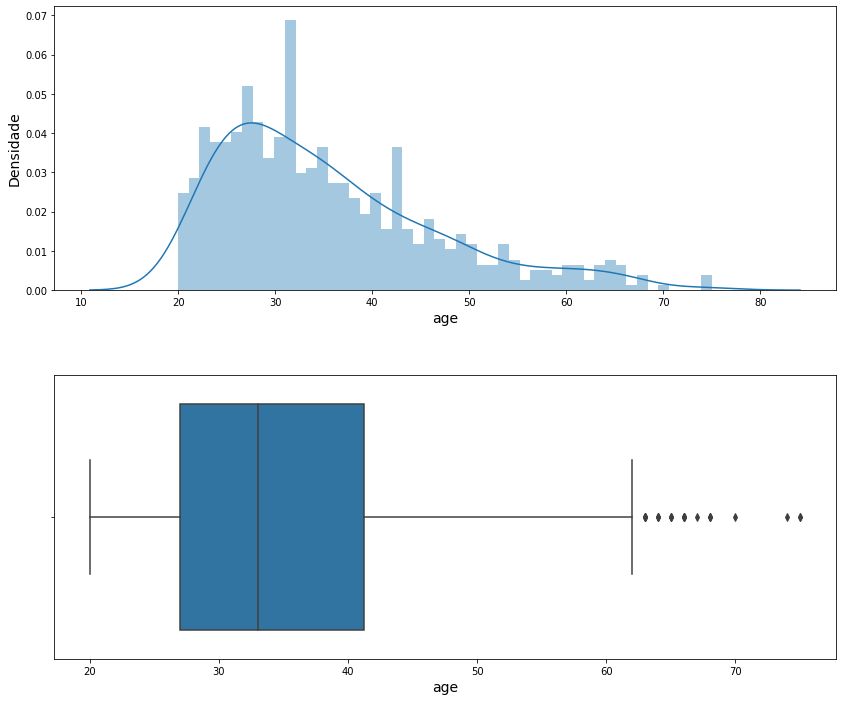

Limites para outliers:
Q1 = 27.0
Q3 = 41.25
FIQ = 14.25
min_outliers = 5.625
max_outliers = 62.625


In [18]:
# Verificação de outliers da variável 'age'
outliers(df1, 'age')

**Observações:**

- Pode-se verificar que a variável `age` tem outliers acima de 62 anos.
- Talvez não se necessário tratá-los pelo fato da distribuição ser assimétrica e não ter tantos dados fora da curva.

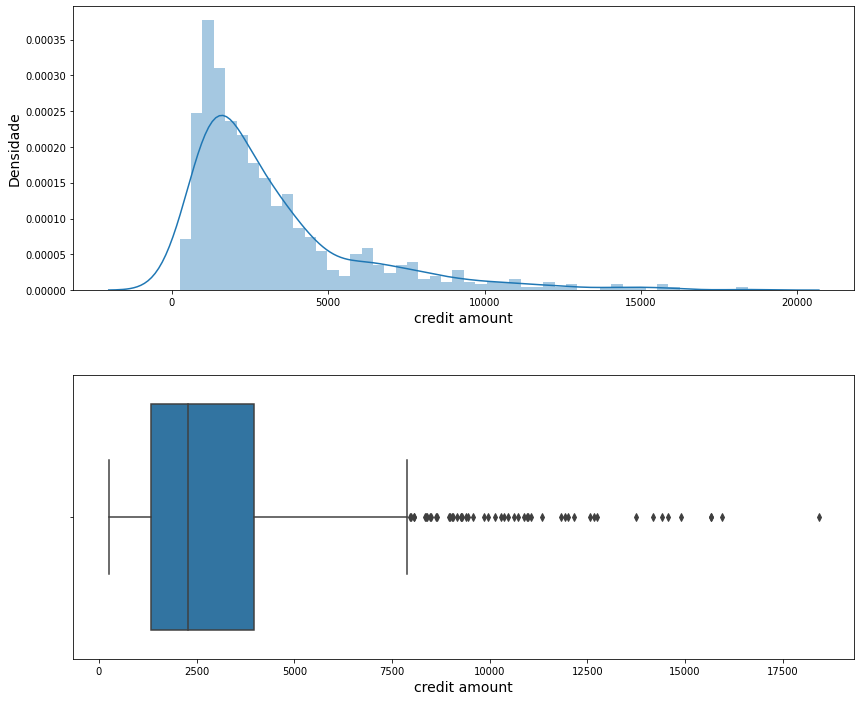

Limites para outliers:
Q1 = 1336.0
Q3 = 3965.25
FIQ = 2629.25
min_outliers = -2607.875
max_outliers = 7909.125


In [19]:
# Verificação de outliers da variável 'credit amount'
outliers(df1, 'credit amount')

**Observações:**

- Pode-se observar que existem valores de créditos dos clientes acima de 7909 euros, que são considerados outliers.

- Nesse caso, como os outliers são mais presentes para as variáveis serão tratados, no módulo de **Pré-Processamento**.

### 1.6.2 Variáveis Categóricas

Já para as **variáveis categóricas**, tem-se as seguintes observações:

In [20]:
var_cat.describe().T

,count,unique,top,freq
sex,700,2,male,486
job,700,4,2,448
housing,700,3,own,504
saving accounts,575,4,little,428
checking account,426,3,little,201
purpose,700,8,car,230
risk,700,2,good,490


**Observações:**

- Cerca de 486 (69%) dos clientes do banco são do gêneno masculino.
- Cerca de 448 (64%) dos clientes do banco têm empregos qualificados.
- Cerca de 504 (72%) dos clientes possuem habitação própria.
- Cerca de 428 (74%) dos clientes possuem uma conta poupança do tipo pequena.
- Cerca de 201 (47%) dos clientes possuem uma conta corrente do tipo pequena. 
- A maioria dos clientes(17.7%) duram 24 meses no banco.
- Cerca de 230 (33%) dos clientes possuem o objetivo de comprar um carro.
- Cerca de 490 (70%) dos clientes possuem risco de crédito bom.

Analisando alguns resultados acima, a maioria dos clientes possuem risco de crédito bom (70%). E isso acontece, pelo fato que a maioria dos clientes possuem empregos qualificados (64%) e habitação própria (72%). Logo, verificarei através da **Análise Exploratória de Dados** as variáveis que explicam a **variável resposta**.

# 2.0 Análise Exploratória de Dados

In [21]:
# Salvando conjunto de dados
df2 = df1.copy()

Em resumo, a importância da **Análise Exploratória de Dados** é compreender e medir forças de como as variáveis impactam no fenômeno que se está modelando. Dessa forma, os objetivos da AED são:

- Ganhar experiência de negócio.

- Entender quais variáveis são importantes para o negócio.

Para realizar a Análise Exploratória de Dados, irei utilizar a biblioteca **Sweetviz** que fornece uma rápida e eficiente análise dos dados. Logo, antes de fazer este passo, farei o pré-processamento da variável target, pois o **SweetViz** trabalha com a variável resposta de forma binária.

                                             |                                                                …


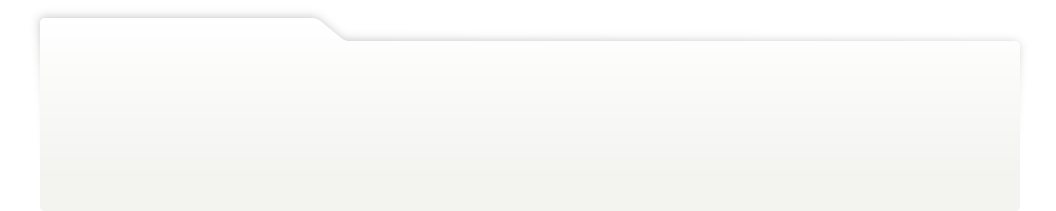
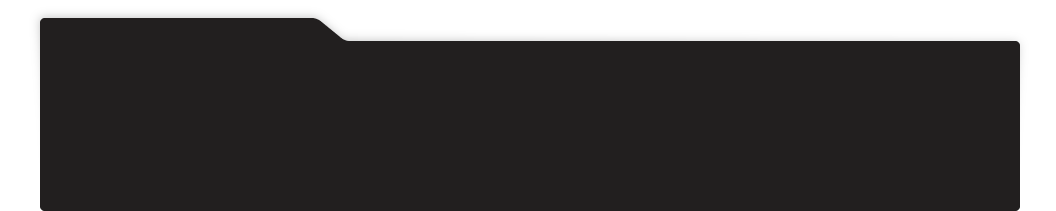
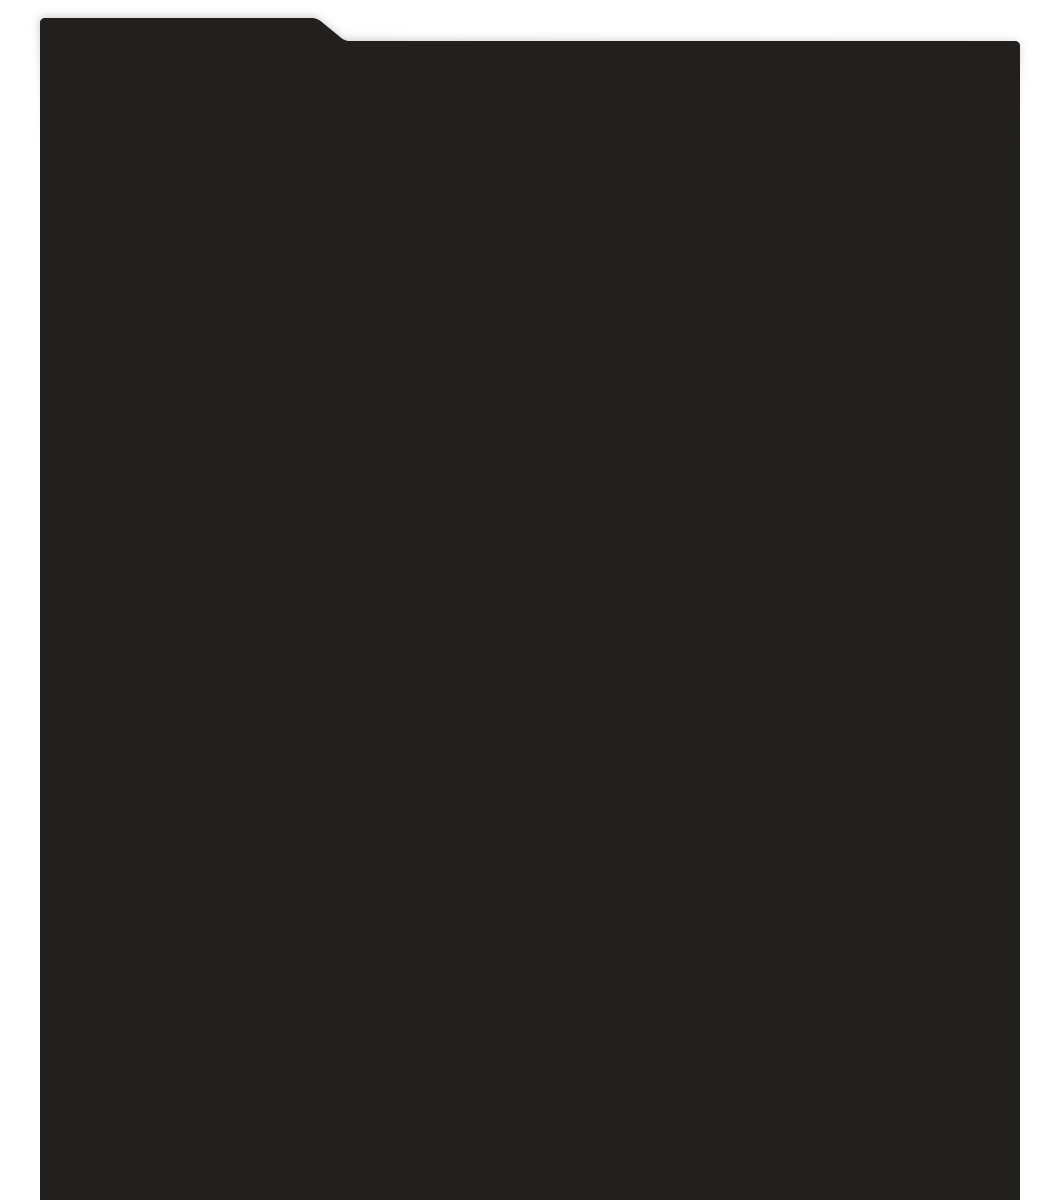
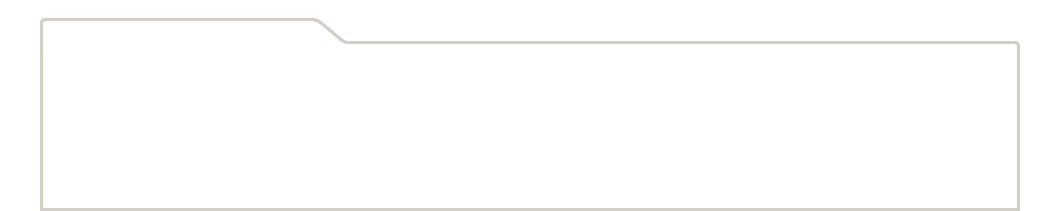
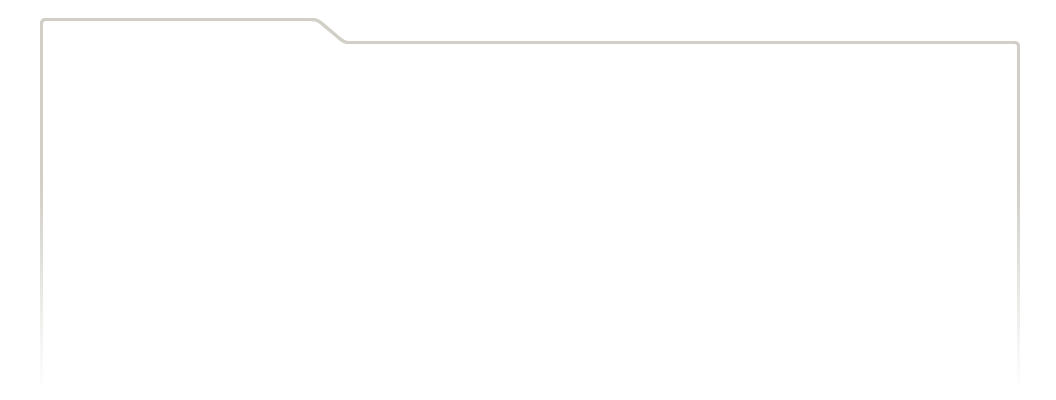
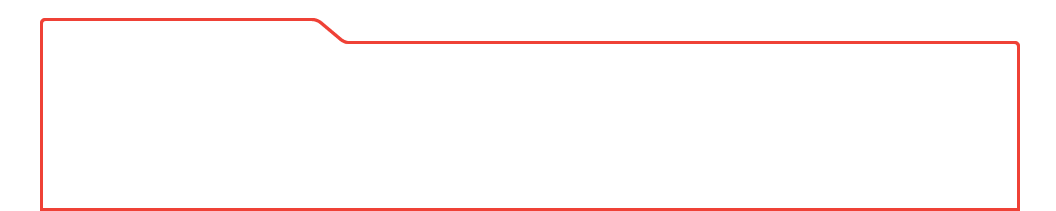
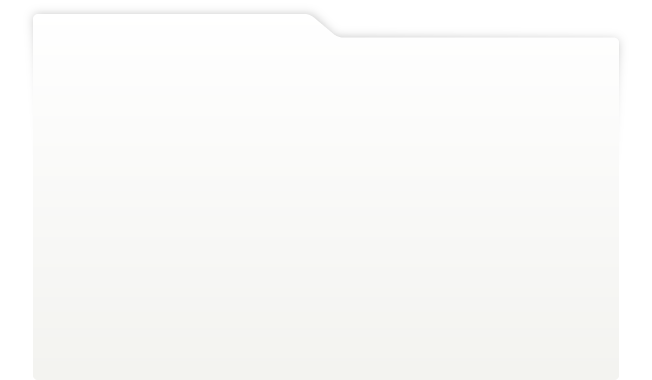
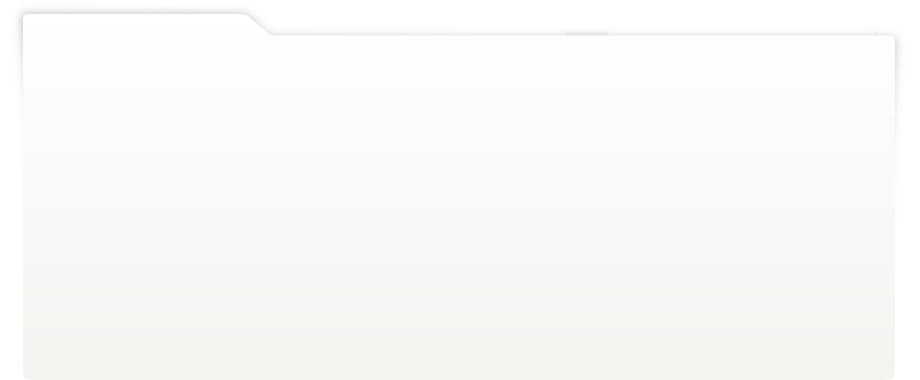
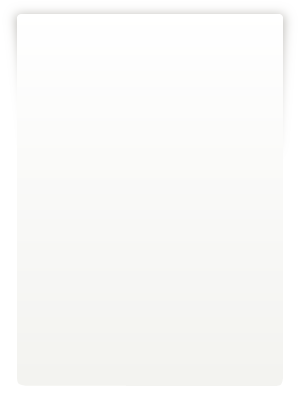
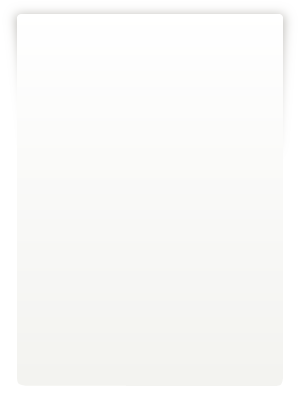
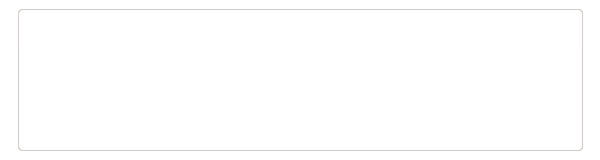
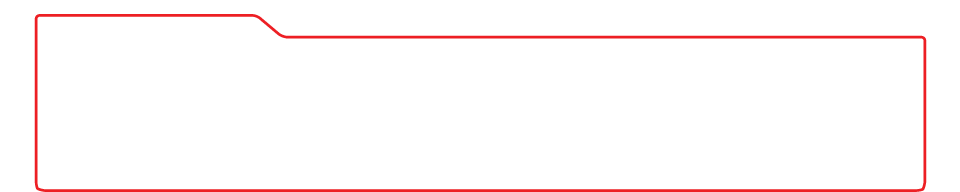
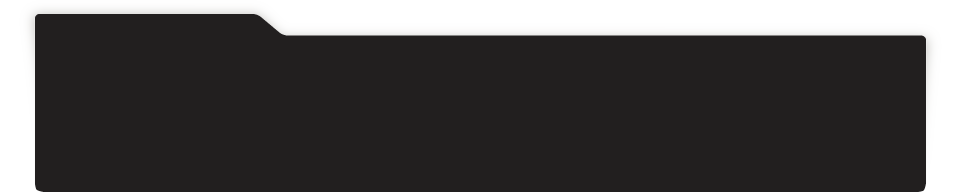
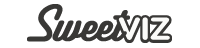
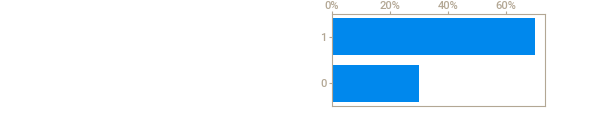
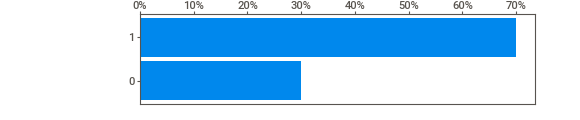
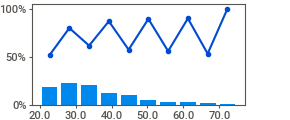
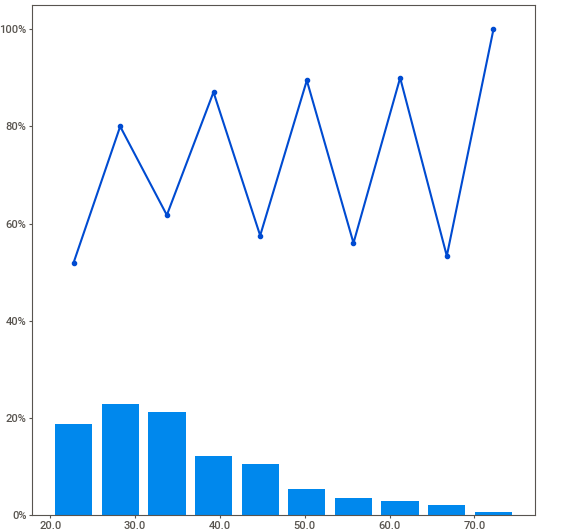
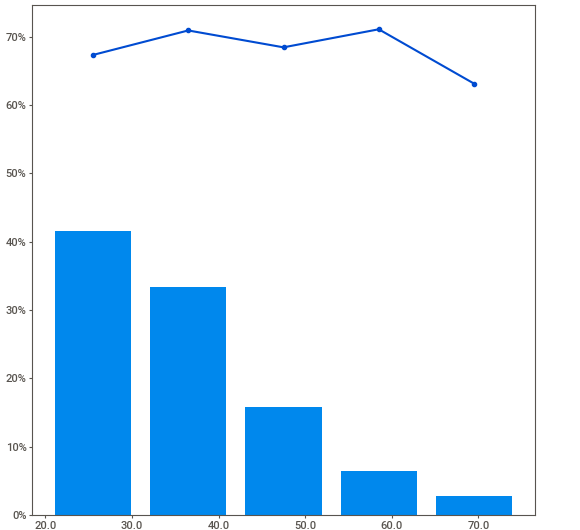
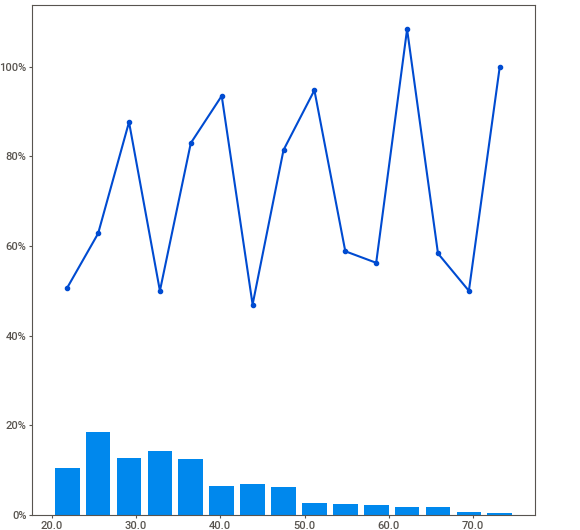
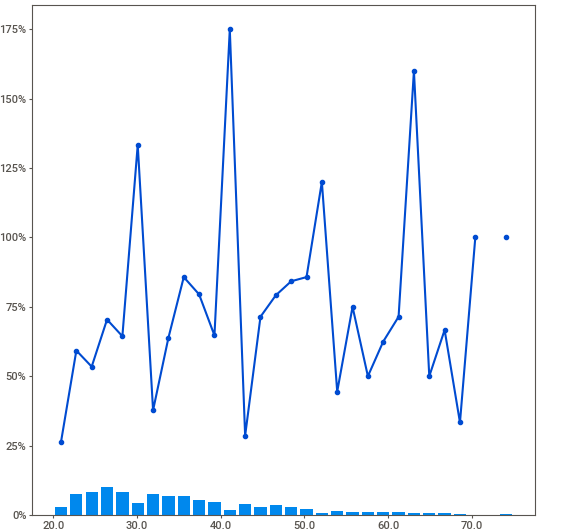
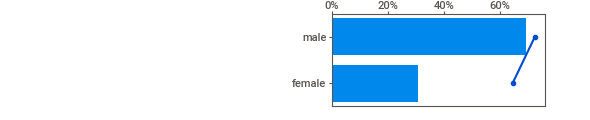
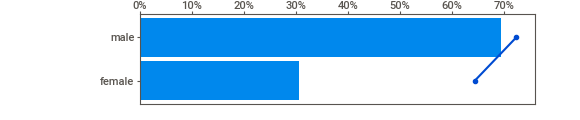
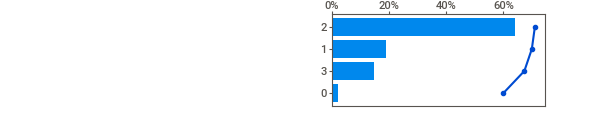
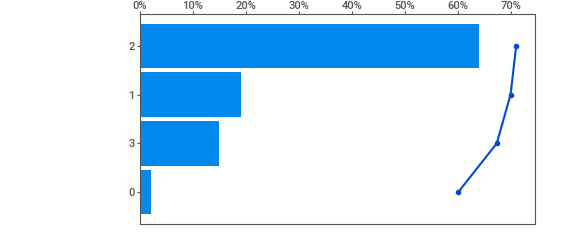
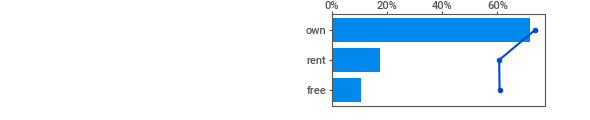
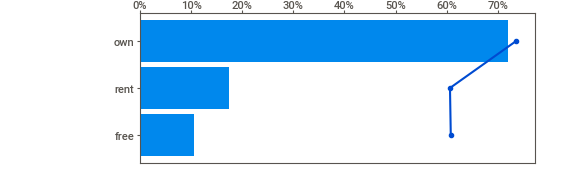
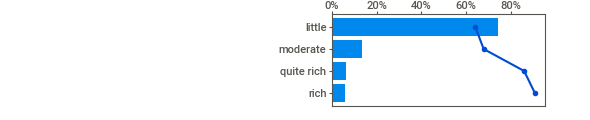
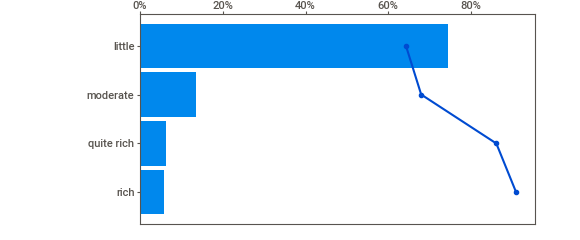
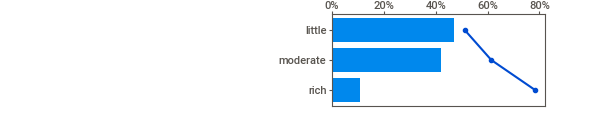
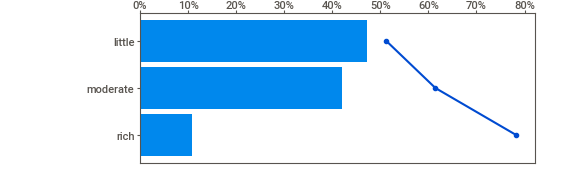
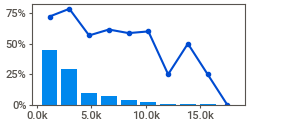
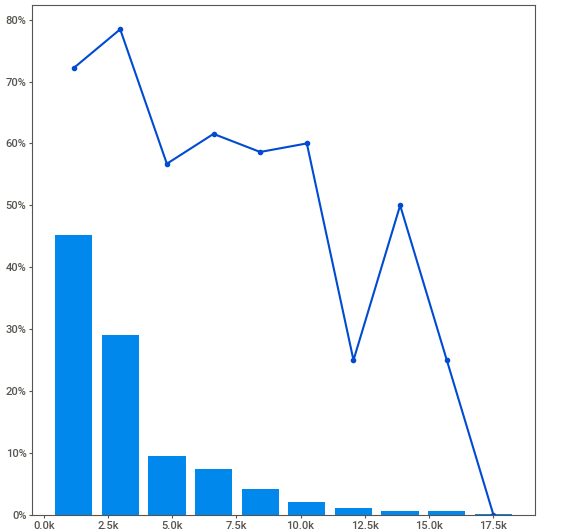
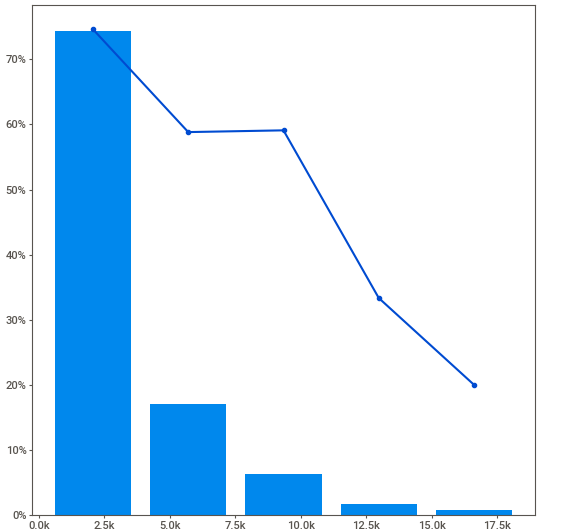
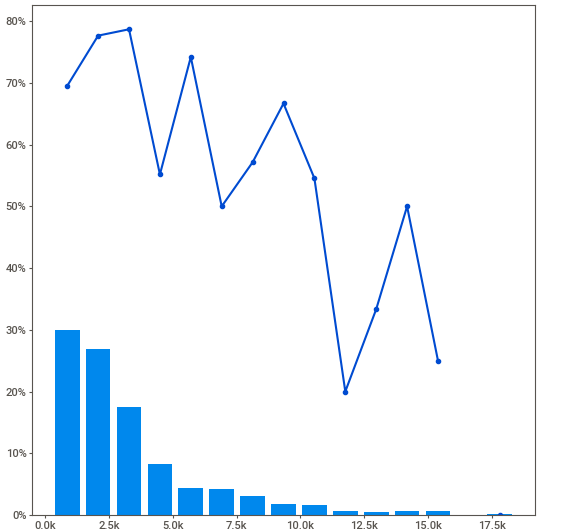
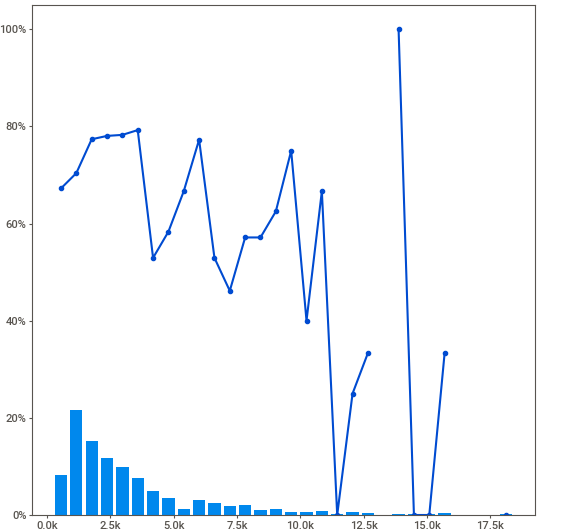
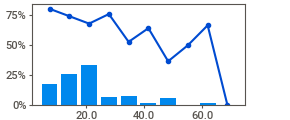
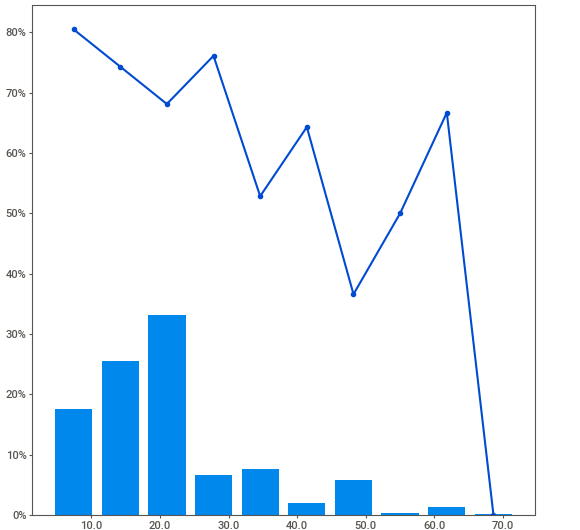
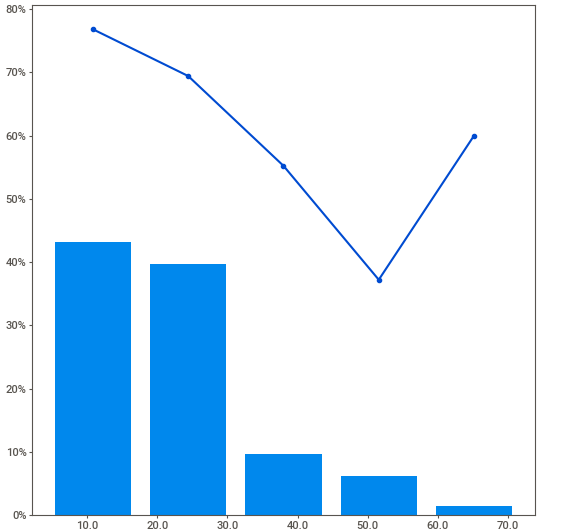
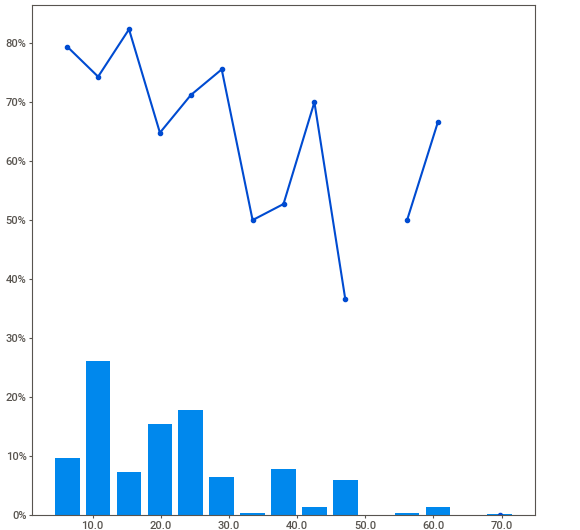
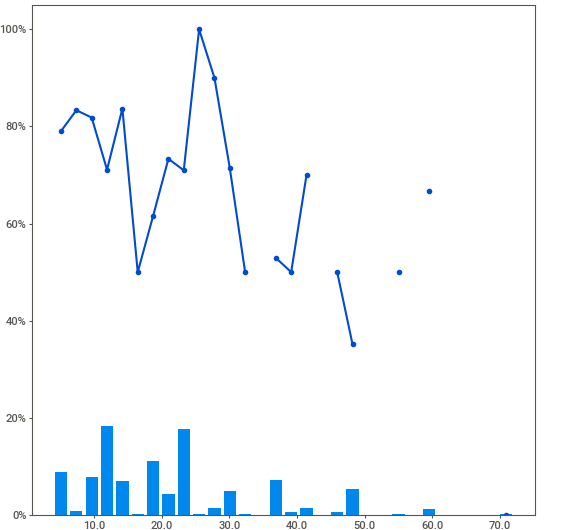
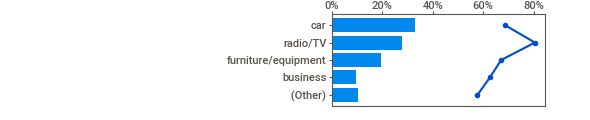
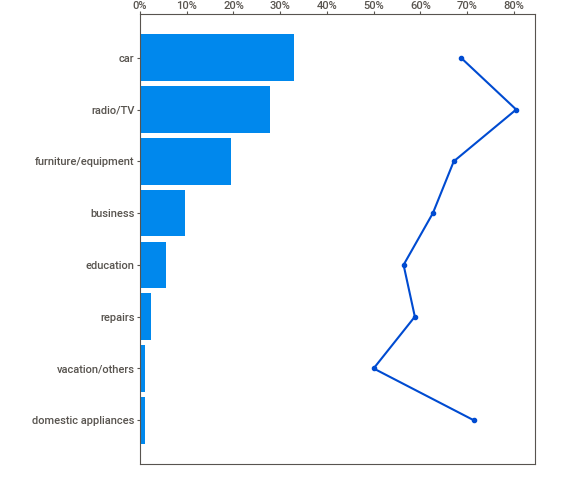
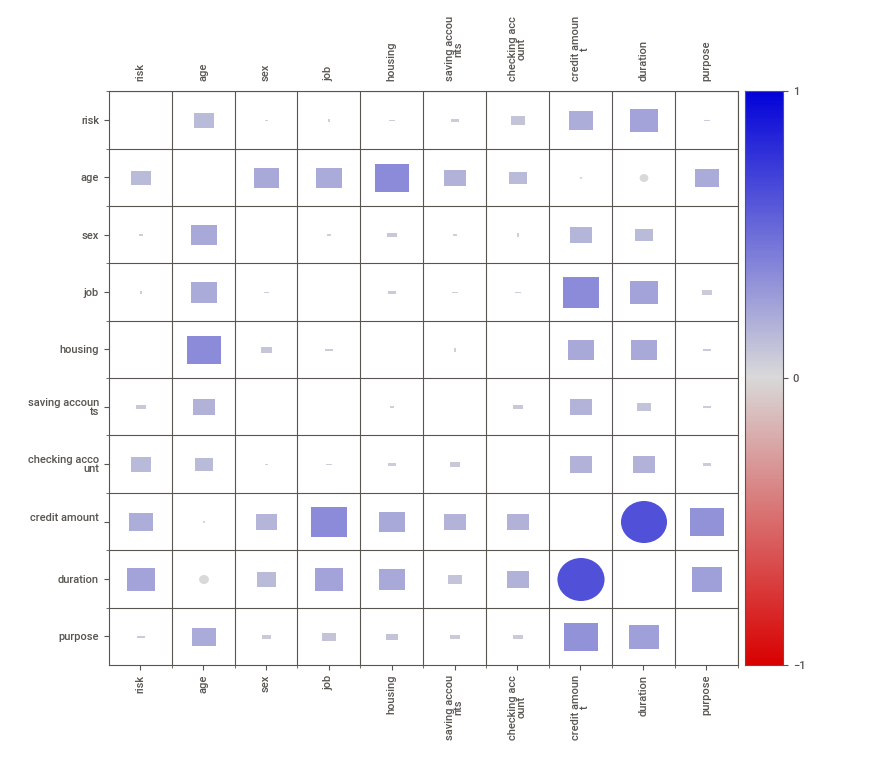
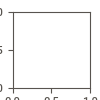

In [22]:
# Convertendo variável risk em binária
df2['risk'] = df2['risk'].apply(lambda x: 1 if x=='good' else 0)

# Análise Exploratória de Dados com SweetViz
eda = sw.analyze(source=df2, target_feat='risk')

# Visualizando Análise Exploratória de Dados
eda.show_notebook()

**Observações Relevantes:**

- Clientes do gênero masculino recebem um maior risco de crédito bom do que clientes do gênero feminino.
- Clientes que tem empregos qualificados recebem mais risco de crédito bom do que clientes que tem apenas um emprego que não é qualificado e também empregos que são altamente qualificados.
- Clientes que tem casa própria recebem mais risco de crédito bom do que clientes que tem casas alugadas ou com o termo 'free'.
- Clientes com conta poupança do tipo rica recebem um maior risco de crédito bom do que clientes com conta poupança muito rica, moderada ou pequena. 
- Clientes com conta corrente do tipo rica recebem um maior risco de crédito bom do que clientes com conta corrente do tipo moderada ou pequena.
- Clientes com crédito de 0 até 5000 euros rebecem um maior risco de crédito bom do que clientes com crédito de 5000 a 10000 euros.
- Clientes com até 25 meses de banco recebem um maior risco de crédito bom do que clientes com mais de 25 meses de banco. Isto é, quanto mais novo é o cliente, mais ele recebe um risco de crédito bom.
- Clientes que tem o objetivo de comprar radio/TV recebem um maior risco de crédito bom do que clientes que tem o objetivo de comprar um carro, mobiliaria/equipamentos e etc.


**Associações Relevantes com a Variável Target:**
- `age` e `risk`: 0.10
- `credit amount`e `risk`: 0.16
- `duration` e `risk`: 0.22

Verifico que as variáveis `age`, `credit amount` e `duration` têm as correlações mais significativas com a variável resposta. Logo, são variáveis que  têm um peso mais significativo para determinar o risco de crédito do cliente. Portanto, farão parte da construção do modelo.

# 3.0 Pré-Processamento

Na etapa de pré-processamento, irei fazer a transformação dos dados para o preparado de treino dos modelos de **Machine Learning**. A razão para isto é que a aprendizagem dos algoritmos é facilitada com dados numéricos. Portanto, serão realizadas as etapas:

- Tratando Dados Faltantes
- Featuring Engineering
- Filtragem de Variáveis
- Preparação dos Dados


In [23]:
# Salvando conjunto de dados
df3 = df2.copy()

## 3.1 Tratando Dados Faltantes

Pode-se verificar, por meio da **Análise Exploratória de Dados**, que essas variáveis não influenciam diretamente na decisão da **variável target**, mas pelo contexto considero features importantes no momento de responder se aquele cliente irá ter um risco de crédito bom ou ruim.
Portanto, tratarei os dados faltantes das variáveis `saving accounts` e `checking account` do que simplesmente excluir seus dados faltantes.

Para a variável `saving accounts`, irei considerar a classe de maior frequência baseando-se no agrupamento desta variável com a variável `sex` e  `age_cat`. Para isso, farei a criação da `age_cat` que define a faixa de idade de cada cliente como: Estudante, Jovem, Adulto e Senhor.

In [24]:
intervalo = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df3['age_cat'] = pd.cut(df3.age, intervalo, labels=cats)

df3['saving accounts'] = df3.groupby(['sex','age_cat'])['saving accounts'].transform(
    lambda x: x.fillna(x.mode()[0]))

Para a variável `checking account` considerarei a sua moda baseando-se no agrupamento desta variável com as variáveis `sex`e `age_cat`.

In [25]:
df3['checking account'] = df3.groupby(['sex','age_cat'])['checking account'].transform(
    lambda x: x.fillna(x.mode()[0]))

## 3.2 Featuring Engineering

Nessa etapa realizarei o processo de **Featuring Engineering**, que é criação de variáveis baseada no conjunto de dados com o propósito de obter mais informações que ajudam a explicar a previsão da **variável resposta**.

### 3.2.1 Year

Criarei a variável `year` que define o tempo de cada cliente conforme a faixa anual.

In [26]:
df3['year'] = str(df3["duration"])
df3.loc[df3["duration"] <= 24, "year"] = "0-2"
df3.loc[(df3["duration"] > 24) & (df3["duration"] <= 48), "year"] = "2-4"
df3.loc[(df3["duration"] > 48) & (df3["duration"] <= 72), "year"] = "4-6"
#df3.loc[(df3["duration"] > 36) & (df3["duration"] <= 48), "year"] = "3-4"
#df3.loc[(df3["duration"] > 48) & (df3["duration"] <= 60), "year"] = "4-5"
#df3.loc[(df3["duration"] > 60) & (df3["duration"] <= 72), "year"] = "5-6"
#df3.loc[(df3["duration"] > 72) & (df3["duration"] <= 84), "year"] = "6-7"

### 3.2.2 Status

Criarei a variável `status` que define a classe de cada cliente em: pobre, médio, superior e rico conforme o crédito disponível.

In [27]:
df3['status'] = pd.qcut(df3['credit amount'],4, labels=['poor', 'mid', 'upper', 'rich'])

## 3.3 Filtragem de  Variáveis

Nesse passo, irei fazer o filtro de variáveis, ou seja, analisarei o conjunto de dados para identificar algum dados que não seja relevante para o projeto. Diante, realizarei os seguintes passos:

- Filtrando Linhas

- Selecionando Colunas

### 3.3.1 Filtrando Linhas

Para a filtragem de linhas, irei filtrar os dados que não são considerados os outliers da variável `credit amount` como visto na seção de Estatística Descritiva do Módulo . Logo,

In [28]:
df3 = df3[df3['credit amount'] <=10000]

### 3.3.2 Selecionando Colunas

Já para a seleção de colunas, irei excluir a variável `duration`, pois criei a variável `year`, na etapa anterior, que define o tempo de cada cliente no banco.

In [29]:
df3 = df3.drop(['duration'], axis=1)

df3.head()

,age,sex,job,housing,saving accounts,checking account,credit amount,purpose,risk,age_cat,year,status
0,31,male,2,own,little,rich,4473,radio/TV,1,Young,2-4,rich
1,46,male,2,own,little,little,1829,radio/TV,1,Adult,0-2,mid
2,27,male,1,own,little,moderate,7418,radio/TV,1,Young,4-6,rich
3,27,female,2,own,little,little,1185,business,1,Young,0-2,poor
4,27,female,2,own,moderate,little,1237,radio/TV,1,Young,0-2,poor


## 3.4 Preparação dos Dados

Para preparar os dados, utilizarei as técnicas de Robust Scalers para as variáveis:

- `age`
- `credit amount`

E já para as demais variáveis o processo de transformação-dumificação.

### 3.4.1 Robust Scaler

A técnica de Robust Scaler redimensiona as variáveis que não tem uma distribuição normal e tem outliers. Como as variáveis `age` e `credit amount` não têm uma distribuição normal e tem outliers, utilizarei esse método.

In [30]:
rs = RobustScaler()

df3['age'] = rs.fit_transform(df3[['age']].values)
pi.dump(rs, open('/home/nickolas/Área de Trabalho/Portfólio/pa005/parametros/age_scaler.pkl', 'wb'))

df3['credit amount'] = rs.fit_transform(df3[['credit amount']].values)
pi.dump(rs, open('/home/nickolas/Área de Trabalho/Portfólio/pa005/parametros/credit_amount_scaler.pkl', 'wb'))

### 3.4.2 Transformação - Dumificação

A técnica de transformação-dumificação é usada para transformar as variáveis categóricas em números binários (1 e 0), em que são criadas inúmeras colunas conforme a quantidade de classes de cada variável. 

In [31]:
df3['purpose'] = df3['purpose'].apply(lambda x: 'car' if x=='car'
                                      else 'radio/TV' if x=='radio/TV'
                                      else 'furniture/equipment' if x=='furniture/equipment'
                                      else 'others')

variaveis_categoricas = ['sex','job', 'housing', 'saving accounts', 'checking account',
           'purpose','age_cat','year', 'status']

df3 = pd.get_dummies(df3, columns=variaveis_categoricas, drop_first=True)

In [32]:
df3.head()

,age,credit amount,risk,sex_male,job_1,job_2,job_3,housing_own,housing_rent,saving accounts_moderate,saving accounts_quite rich,saving accounts_rich,checking account_moderate,checking account_rich,purpose_furniture/equipment,purpose_others,purpose_radio/TV,age_cat_Young,age_cat_Adult,age_cat_Senior,year_2-4,year_4-6,status_mid,status_upper,status_rich
0,-0.142857,0.967094,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1
1,0.928571,-0.162821,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
2,-0.428571,2.225641,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1
3,-0.428571,-0.438034,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,-0.428571,-0.415812,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


# 4.0 Seleção de Variáveis

A seleção de variáveis é importante para facilitar a compreensão dos algoritmos de **Machine Learning**. Esse passo verificará quais variáveis do conjunto de dados são colineares, ou seja, variáveis que explicam a mesma informação. Portanto, é preciso remover essas variáveis.

Para fazer a seleção de variáveis utilizarei o algoritmo **Decision Tree Classifier** que calcula quais as variáveis são mais importantes para o modelo. Antes separarei a variável resposta das demais variáveis.

In [33]:
# Salvando conjunto de dados
df4 = df3.copy()

## 4.1 Separando Variável Dependentes e Variável Target

In [34]:
# Variáveis Dependentes
x_treino = df4.drop(['risk'], axis=1)

# Variável Target
y_treino = df4['risk'].copy()

# Verificando dimensão do conjunto de treino
x_treino.shape, y_treino.shape

((673, 24), (673,))

## 4.2 Random Forest como Seleção de Variáveis

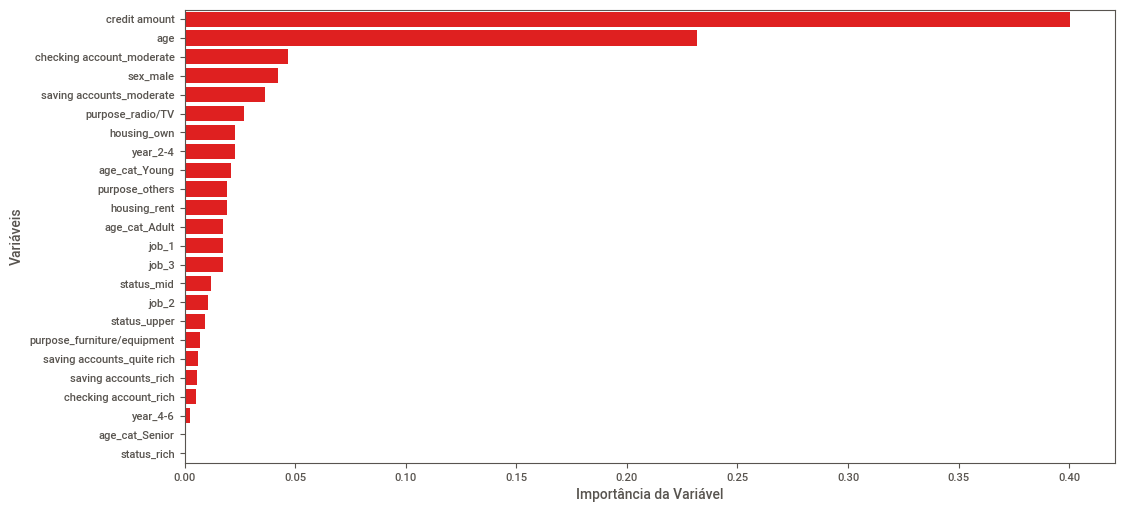

In [35]:
# Definindo modelo Decision Tree Classifier
rf = DecisionTreeClassifier(random_state=42)
rf.fit(x_treino, y_treino)

feat_imp = pd.DataFrame({'Variáveis': x_treino.columns,
    'Importância da Variável': rf.feature_importances_}).sort_values('Importância da Variável',
                                                                    ascending=False).reset_index(drop=True)

plt.subplots(figsize=(12,6))
sns.barplot(x= 'Importância da Variável', y='Variáveis',data=feat_imp, orient='h', color='red')
plt.show()

**Observação:**

- As variáveis que o algoritmo **Decision Classifier** selecionou como sendo as mais importantes são `credit amount` e `age`. Temos features que não tem tanta importância, mas irei selecionar todas as variáveis para compor o modelo.

# 5.0 Machine Learning

Neste módulo, aplicarei os modelos de **Machine Learning** em que a motivação para utilizar estes algoritmos é construir um modelo inteligente capaz de classificar se cada cliente vai ter um **risco de crédito** bom ou ruim. Para isso aplicarei algoritmos de aprendizado de máquina supervisionado como:


- Decision Tree
- KNeighbors Classifier (KNN)
- Random Forest Classifier

Nesses algoritmos aplicarei diferentes parâmetros para testar diversos resultados.

## 5.1 Modelos de Machine Learning

Abaixo, coloco os modelos com diferentes parâmetros numa lista para serem treinados utilizando os dados de treino. 

In [36]:
modelos = [
           DecisionTreeClassifier(random_state=1),
           DecisionTreeClassifier(max_depth=3, random_state=2),
           DecisionTreeClassifier(max_depth=5, random_state=3),
           DecisionTreeClassifier(max_depth=7, random_state=4),
           KNeighborsClassifier(n_neighbors=5),
           KNeighborsClassifier(n_neighbors=10),
           KNeighborsClassifier(n_neighbors=15),
           RandomForestClassifier(random_state=8),
           RandomForestClassifier(max_depth=7, random_state=9),
           RandomForestClassifier(max_depth=10, random_state=10),
           RandomForestClassifier(max_depth=15, random_state=11)
]

nome_modelos = [
                'Decision Tree Classifier()',
                'Decision Tree Classifier(max_depth=3)',
                'Decision Tree Classifier(max_depth=5)',
                'Decision Tree Classifier(max_depth=7)',
                'KNeighboors Classifier()',
                'KNeighboors Classifier(n_estimators=10)',
                'KNeighboors Classifier(n_estimators=15)',
                'Random Forest Classifier()',
                'Random Forest Classifier(max_depth=7)',
                'Random Forest Classifier(max_depth=10)',
                'Random Forest Classifier(max_depth=15)']
                

Treinando modelos com a **função que contém a validação cruzada**

In [37]:
machine_learning(modelos, nome_modelos, x_treino, y_treino)

Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando KNeighborsClassifier...
Treinando KNeighborsClassifier...
Treinando KNeighborsClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...


,Acurácia,Precisão,Sensibilidade,F1-Score
Decision Tree Classifier(),0.590035,0.717998,0.699424,0.706577
Decision Tree Classifier(max_depth=3),0.701383,0.722476,0.943484,0.817859
Decision Tree Classifier(max_depth=5),0.659548,0.722055,0.849734,0.778421
Decision Tree Classifier(max_depth=7),0.652217,0.730360,0.812101,0.767729
KNeighboors Classifier(),0.652458,0.715634,0.847518,0.775540
KNeighboors Classifier(n_estimators=10),0.659899,0.721933,0.849690,0.780172
KNeighboors Classifier(n_estimators=15),0.683670,0.710728,0.935372,0.807353
Random Forest Classifier(),0.655465,0.717760,0.849778,0.777885
Random Forest Classifier(max_depth=7),0.692471,0.715770,0.941534,0.813106
Random Forest Classifier(max_depth=10),0.686589,0.724285,0.903989,0.803950


**Observações:**

- Analisando os resultados e pensando no contexto de negócio, o modelo preferível é que tenha um bom **F1-Score**, pois o que me interessa é ter o resultado dessa métrica mais significativa, nas quais a **Precisão** e a **Sensibilidade** sejam aumentadas e equilibradas pela média harmonica.

Portanto, irei escolher alguns modelos para serem avaliado no conjunto de teste.

**Modelos Escolhidos:**

- Decision Tree Classifier(max_depth=3)
- Random Forest Classifier(max_depth=7)
- Random Forest Classifier(max_depth=10)

## 5.2 Balanceando os Dados

Para verificar a melhora do desempenho dos modelos, irei balancear os dados, na qual é usada uma técnica que cria dados sintéticos com a biblioteca **SMOTE**.

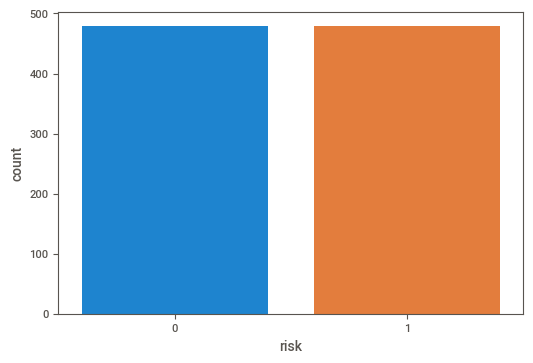

In [38]:
oversampling = SMOTE()

# Balanceando dados de treino
x_treino_SMOTE, y_treino_SMOTE = oversampling.fit_resample(x_treino,y_treino)

# Verificando dados balanceados
sns.countplot(y_treino_SMOTE);

**Observação:**

- As classes da variável target está balanceada com as classes tendo a mesma frequência.

## 5.3. Machine Learning Dados Balanceados

In [39]:
machine_learning(modelos, nome_modelos, x_treino_SMOTE, y_treino_SMOTE)

Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando KNeighborsClassifier...
Treinando KNeighborsClassifier...
Treinando KNeighborsClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...


,Acurácia,Precisão,Sensibilidade,F1-Score
Decision Tree Classifier(),0.681700,0.709570,0.645124,0.671191
Decision Tree Classifier(max_depth=3),0.623136,0.678965,0.509353,0.567216
Decision Tree Classifier(max_depth=5),0.645077,0.691371,0.561746,0.612962
Decision Tree Classifier(max_depth=7),0.682599,0.738148,0.590824,0.652620
KNeighboors Classifier(),0.716195,0.797831,0.590780,0.675935
KNeighboors Classifier(n_estimators=10),0.690044,0.814988,0.505142,0.620277
KNeighboors Classifier(n_estimators=15),0.695208,0.771743,0.572030,0.652195
Random Forest Classifier(),0.778871,0.828671,0.726507,0.769917
Random Forest Classifier(max_depth=7),0.738026,0.769937,0.709796,0.733764
Random Forest Classifier(max_depth=10),0.756886,0.790701,0.728635,0.753565


**Observação:**

- Os dados balanceados apresentam uma melhora significativa nos resultados dos modelos. Logo, o modelo **Random Forest Classifier(max_depth=15)** apresenta uma **Acurácia**, **Precisão**, **Sensibilidade** e **F1-Score** melhor que os demais modelos.

Portanto, escolherei o modelo **Random Forest Classifier(max_depth=15)** para ser avaliado nos dados de teste.

**Modelo Escolhido:**

- Random Forest Classifier(max_depth=15)

# 6.0 Hipertunagem de Parâmetros

Em machine Learning, a hipertunagem de parâmetros é a escolha de um conjunto de hiperparâmetros ótimos para um algoritmo, cujo valores são utilizados para controlar o processo de aprendizagem. Em contraste, os valores de outros parâmetros (tipicamente pesos de nós) são aprendidos.

Portanto, utilizei a técnica de **RandomSearchCV**, pois método aqui descrito é um tipo de pesquisa aleatória local em que cada iteração depende da solução candidata da iteração anterior. Por isso, gastarei menos tempo para obter o resultado.

## 6.1 Random Search

### 6.1.1 Dados Não-Balanceados

#### 6.1.1.1 Decision Tree Classifier

In [40]:
# Modelo escolhido
dt_clf = DecisionTreeClassifier(random_state=2)

parametros_dt = {'max_depth': [1,2,4,6,8,9,10,11,12,15,17,18,19,20]}

In [41]:
hipertunagem(dt_clf, x_treino, y_treino, parametros_dt, tipo='random', n_iter=50)

Fitting 30 folds for each of 14 candidates, totalling 420 fits

F1-Score: 0.8316
Melhores parâmetros: {'max_depth': 1}



DecisionTreeClassifier(max_depth=1, random_state=2)

#### 6.1.1.2 Random Forest Classifier

In [42]:
rf_clf_tun = RandomForestClassifier(random_state=45)

parametros_rf_tun = {'max_depth': [1,3,5,7,10,15,16,17,18,19,20,25,30]}

In [43]:
hipertunagem(rf_clf_tun, x_treino, y_treino, parametros_rf_tun, tipo='random', n_iter=50)

Fitting 30 folds for each of 13 candidates, totalling 390 fits

F1-Score: 0.8316
Melhores parâmetros: {'max_depth': 1}



RandomForestClassifier(max_depth=1, random_state=45)

### 6.1.2 Dados Balanceados

In [44]:
# Modelo Escolhido 
rf_clf = RandomForestClassifier(random_state=8)

parametros = {'max_depth': [1,3,5,7,10,15,16,17,18,19,20,25,30]}                                                        

In [45]:
hipertunagem(rf_clf, x_treino_SMOTE, y_treino_SMOTE, parametros, tipo='random', n_iter=50)

Fitting 30 folds for each of 13 candidates, totalling 390 fits

F1-Score: 0.7556
Melhores parâmetros: {'max_depth': 19}



RandomForestClassifier(max_depth=19, random_state=8)

## 6.2 Comparando Modelo Base x Modelo Hipertunado no Conjunto de Treino

### 6.2.1 Dados Não-Balanceados

In [46]:
modelos_dt_rf_clf = [DecisionTreeClassifier(max_depth=3, random_state=2),
                     DecisionTreeClassifier(max_depth=1, random_state=20),
                     RandomForestClassifier(max_depth=7, random_state=9),
                     RandomForestClassifier(max_depth=10, random_state=10),
                     RandomForestClassifier(max_depth=1, random_state=45)
                 ]

nome_modelos_dt_clf = ['Decision Tree Classifier(max_depth=3)', 'Decision Tree Classifier(max_depth=1)',
                       'Random Forest Classifier(max_depth=7)', 'Random Forest Classifier(max_depth=10)',
                       'Random Forest Classifier(max_depth=1)']

machine_learning(modelos_dt_rf_clf, nome_modelos_dt_clf, x_treino, y_treino)

Treinando DecisionTreeClassifier...
Treinando DecisionTreeClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...
Treinando RandomForestClassifier...


,Acurácia,Precisão,Sensibilidade,F1-Score
Decision Tree Classifier(max_depth=3),0.701383,0.722476,0.943484,0.817859
Decision Tree Classifier(max_depth=1),0.711765,0.711765,1.000000,0.831602
Random Forest Classifier(max_depth=7),0.692471,0.715770,0.941534,0.813106
Random Forest Classifier(max_depth=10),0.686589,0.724285,0.903989,0.803950
Random Forest Classifier(max_depth=1),0.711765,0.711765,1.000000,0.831602


- Analisando as métricas **F1-Score** e **Acurácia**,  os modelos **Decision Tree Classifier(max_depth=1)** e **Random Forest Classifier(max_depth=1)** são que tem desempenhos melhores. Porém, irei testar todos esses modelos no conjunto de teste.

### 6.2.2 Dados Balanceados

In [47]:
modelos_rf_clf = [RandomForestClassifier(max_depth=19, random_state=8), 
                  RandomForestClassifier(max_depth=15, random_state=8)]

nomes_modelos_rf_cfl = ['Random Forest Classifier(max_depth=19)', 'Random Forest Classifier(max_depth=15)']

machine_learning(modelos_rf_clf, nomes_modelos_rf_cfl, x_treino_SMOTE, y_treino_SMOTE)

Treinando RandomForestClassifier...
Treinando RandomForestClassifier...


,Acurácia,Precisão,Sensibilidade,F1-Score
Random Forest Classifier(max_depth=19),0.781952,0.830247,0.732757,0.773680
Random Forest Classifier(max_depth=15),0.770439,0.813516,0.732624,0.764387


**Observações:**

- O modelo base **Random Forest Classifier(max_depth=19)** apresenta um desempenho melhor do que o modelo hipertunado **Random Forest Classifier(max_depth=15)**. Logo, esses modelos treinados com dados balanceados apresentam performance melhor do que os modelos treinados com dados não balanceados. Porém, irei verificar se essas performances continuam boas no conjunto de teste.

# 7. 0 Conjunto de Dados de Testes

Com os modelos escolhidos, irei testá-los no conjunto de dados de teste. Antes irei carregar o dataframe.

In [48]:
# Carregando conjunto de dados de teste
teste = pd.read_csv('/home/nickolas/Área de Trabalho/Portfólio/pa005/data/teste.csv')

## 7.1 Preparando Dados de Teste

Com o conjunto de dados de teste carregado, irei fazer o preparo dos dados conforme o pré-processamento do conjunto de treino. 

In [49]:
teste = preparacao_dados(teste)
teste.head()

,age,credit amount,risk,sex_male,job_1,job_2,job_3,housing_own,housing_rent,saving accounts_moderate,saving accounts_quite rich,saving accounts_rich,checking account_moderate,checking account_rich,purpose_furniture/equipment,purpose_others,purpose_radio/TV,age_cat_Young,age_cat_Adult,age_cat_Senior,year_2-4,year_4-6,status_mid,status_upper,status_rich
0,0.588235,1.377914,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
1,0.647059,-0.772714,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,0.823529,1.088938,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
3,-0.470588,0.447280,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4,-0.588235,1.964693,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


### 7.1.1 Seleção da Variável Alvo e Variáveis do Conjunto de Teste

In [50]:
# Variáveis Dependentes
x_teste = teste.drop(['risk'], axis=1)

# Variável Alvo
y_teste = teste['risk'].copy()

## 7.2 Performance dos Modelos no Conjunto de Teste

Com os dados de teste já preparados, testarei os modelos treinados para verificar suas performances. Logo, testarei os modelos treinados com os **dados balanceados e dados não-balanceados**.

### 7.2.1 Dados Balanceados

In [51]:
# Dados Balanceados
teste_modelo_rfc1, cm = performance_dados_teste(x_treino_SMOTE, y_treino_SMOTE, x_teste, y_teste,
                        RandomForestClassifier(max_depth=15, random_state=8), 
                        'Random Forest Classifier(max_depth=17)')

teste_modelo_rfc1

,Acurácia,Precisão,Sensibilidade,F1-Score
Random Forest Classifier(max_depth=17),0.613333,0.730392,0.709524,0.719807


In [52]:
# Dados Balanceados
teste_modelo_rfc2, cm = performance_dados_teste(x_treino_SMOTE, y_treino_SMOTE, x_teste, y_teste, 
                        RandomForestClassifier(max_depth=19, random_state=8),'Random Forest Classifier()')
teste_modelo_rfc2

,Acurácia,Precisão,Sensibilidade,F1-Score
Random Forest Classifier(),0.593333,0.709524,0.709524,0.709524


**Observações:**

- Analisando as performances dos modelos nos dados de teste, verifico que o desempenho nos dados de testes está abaixo. Portanto, pode estar acontecendo o processo de **Overfiting** no modelo

### 7.2.2 Dados Não Balanceados

In [53]:
# Dados Não Balanceados
teste_modelo_dtc1, cm = performance_dados_teste(x_treino, y_treino, x_teste, y_teste,
                        DecisionTreeClassifier(max_depth=3, random_state=2), 
                        'Decision Tree Classifier(max_depth=3)')
teste_modelo_dtc1

,Acurácia,Precisão,Sensibilidade,F1-Score
Decision Tree Classifier(max_depth=3),0.703333,0.72,0.942857,0.816495


In [54]:
# Dados Não Balanceados
teste_modelo_dtc2, cm = performance_dados_teste(x_treino, y_treino, x_teste, y_teste,
                    DecisionTreeClassifier(max_depth=1, random_state=20),
                    'Decision Tree Classifier(max_depth=1)')

teste_modelo_dtc2

,Acurácia,Precisão,Sensibilidade,F1-Score
Decision Tree Classifier(max_depth=1),0.7,0.7,1.0,0.823529


In [55]:
# Dados Não Balanceados
teste_modelo_rfc3, cm = performance_dados_teste(x_treino, y_treino, x_teste, y_teste, 
                        RandomForestClassifier(max_depth=7, random_state=9),
                        'Random Forest Classifier(max_depth=7)')
teste_modelo_rfc3

,Acurácia,Precisão,Sensibilidade,F1-Score
Random Forest Classifier(max_depth=7),0.676667,0.699647,0.942857,0.803245


In [56]:
# Dados Não Balanceados
teste_modelo_rfc4, cm = performance_dados_teste(x_treino, y_treino, x_teste, y_teste, 
                        RandomForestClassifier(max_depth=10, random_state=10),
                        'Random Forest Classifier(max_depth=10)')
teste_modelo_rfc4

,Acurácia,Precisão,Sensibilidade,F1-Score
Random Forest Classifier(max_depth=10),0.7,0.715827,0.947619,0.815574


In [57]:
teste_modelo_rfc5, cm = performance_dados_teste(x_treino, y_treino, x_teste, y_teste,
                    RandomForestClassifier(max_depth=1, random_state=45),
                    'Random Forest Classifier(max_depth=1)')

teste_modelo_rfc5

,Acurácia,Precisão,Sensibilidade,F1-Score
Random Forest Classifier(max_depth=1),0.7,0.7,1.0,0.823529


**Observações:**

- Analisando o desempenho de todos os modelos, o algoritmo **Random Forest Classifier(max_depth=1)** e **Decision Tree Classifier(max_depth=1)** apresentam a ter as melhores performances, levando em consideração as métricas **Acurácia** (70%), **Precisão** (70%), **Sensibilidade** (100%) e **F1-Score** (82.35%). Logo, escolherei a Random Forest Classifier.

## 7.3 Avaliação do Modelo

Considerando as métricas do modelo **Random Forest Classifier(max_depth=1)**, posso dizer que o modelo acerta com precisão 7 a cada 10 clientes, se terá um risco de crédito bom ou ruim. Enquanto que a probabilidade de o cliente ter, de fato, um risco de crédito bom é de 100%, que é sua sensibilidade. Logo, a combinação da precisão com a sensibilidade pela média harmônica é 82.35%, na qual para a quantidade de dados utilizados no conjunto de dados é um desempenho do modelo satisfatório, nesse primeiro momento.

Logo, para melhorar a performance o modelo e equilibrar mais as métricas entre precisão e sensibilidade é necessário a utilização de mais dados para que o mesmo tenha uma aprendizagem melhor. 

Não foram utilizados mais parâmetros no modelo para não aumentar sua complexidade. 

## 7.4 Salvando Melhor Modelo 

Irei salvar o melhor modelo num arquivo pickel.

In [58]:
rf_clf = RandomForestClassifier(max_depth=1, random_state=45)
rf_clf.fit(x_treino, y_treino)

RandomForestClassifier(max_depth=1, random_state=45)

In [59]:
# Salvar modelo Random Forest
with open('/home/nickolas/Área de Trabalho/Portfólio/pa005/modelo/random_forest_best.pkl', 'wb') as file:
    pi.dump(rf_clf, file)

# 8.0 Deploy do Modelo para Produção

Nesse úlima etapa, colocarei o modelo em produção. A motivação para esta etapa é tornar as previsões do modelo acessíveis a qualquer consumidor. Portanto, irei criar uma arquitetura de produção com as seguintes tarefas:

**Lista de Tarefas**

- Criar uma classe com as tranformações e codificações dos dados (Riscodecredito.py)


- Criar uma  API (Handler.py)


- Criar um script para a API

O Deploy do Modelo será colocado em produção em máquina local (Local Host) no [Heroku](https://id.heroku.com/login) (Cloud).

## 8.1 Classe Riscodecredito

Classe com todas as transformações no conjunto de treino para aplicá-los no conjunto de teste em Deploy.

In [60]:
import pandas as pd
import numpy  as np
import inflection
import pickle as pi


class riscodecredito(object):
    
    def __init__(self):
        self.home_path = '/home/nickolas/Área de Trabalho/Portfólio/pa005/'
        self.age_scaler = pi.load(open(self.home_path + 'parametros/age_scaler.pkl', 'rb'))
        self.credit_amount_scaler = pi.load(open(self.home_path + 'parametros/credit_amount_scaler.pkl', 'rb'))
        
        
        
    def descricao_dados(self, df1):
        
        ## Renomeando Colunas
        colunas_velhas = ['Age', 'Sex', 'Job', 'Housing',
                          'Saving accounts', 'Checking account', 'Credit amount', 'Duration',
                          'Purpose']

        snakecase = lambda x: inflection.underscore(x)

        colunas_novas = list(map(snakecase, colunas_velhas))

        df1.columns = colunas_novas

        # Excluindo colunas 
        #df1 = df1.drop(['unnamed: 0', 'unnamed: 0.1'], axis=1)
    
        # Mudança Dados
        df1['job'] = df1['job'].astype('str')
    
        return df1
    
    def pre_processamento_1(self, df2):

        # Convertendo variável risk em binária
        #df2['risk'] = df2['risk'].apply(lambda x: 1 if x=='good' else 0)
        
        # Tratamento Dados Faltantes
        intervalo = (18, 25, 35, 60, 120)
        cats = ['Student', 'Young', 'Adult', 'Senior']
        df2['age_cat'] = pd.cut(df2.age, intervalo, labels=cats)
        
        df2['saving accounts'] = df2.groupby(['sex', 'age_cat'])['saving accounts'].transform(
        lambda x: x.fillna(x.mode()[0]))
        
        df2['checking account'] = df2.groupby(['sex', 'age_cat'])['checking account'].transform(
        lambda x: x.fillna(x.mode()[0]))
        
        df2['year'] = str(df2["duration"])
        df2.loc[df2["duration"] <= 24, "year"] = "0-2"
        df2.loc[(df2["duration"] > 24) & (df2["duration"] <= 48), "year"] = "2-4"
        df2.loc[(df2["duration"] > 48) & (df2["duration"] <= 72), "year"] = "4-6"
        #df3.loc[(df3["duration"] > 36) & (df3["duration"] <= 48), "year"] = "3-4"
        #df3.loc[(df3["duration"] > 48) & (df3["duration"] <= 60), "year"] = "4-5"
        #df3.loc[(df3["duration"] > 60) & (df3["duration"] <= 72), "year"] = "5-6"
        #df3.loc[(df3["duration"] > 72) & (df3["duration"] <= 84), "year"] = "6-7"
        
        df2['status'] = pd.qcut(df2['credit amount'],4, labels=['poor', 'mid', 'upper', 'rich'])
        
        # Selecionado Colunas
        df2 = df2.drop(['duration'], axis=1)
        
        return df2
    
    def pre_processamento_2(self, df3):
        
        df3['age'] = self.age_scaler.fit_transform(df3[['age']].values)


        df3['credit amount'] = self.credit_amount_scaler.fit_transform(df3[['credit amount']].values)

        df3['purpose'] = df3['purpose'].apply(lambda x: 'car' if x=='car'
                                      else 'radio/TV' if x=='radio/TV'
                                      else 'furniture/equipment' if x=='furniture/equipment'
                                      else 'others')

        variaveis_categoricas = ['sex','job', 'housing', 'saving accounts', 'checking account',
                                 'purpose','age_cat','year', 'status']

        df3 = pd.get_dummies(df3, columns=variaveis_categoricas, drop_first=True)
        
        return df3
    
    def get_prediction(self, modelo, dados_originais, dados_teste):
        # predições
        predicoes = modelo.predict(dados_teste)
        
        # Juntar predições nos dados originais
        dados_originais['predição'] = predicoes
        
        return dados_originais.to_json(orient = 'records')

## 8.2 API Handler

In [61]:
import pickle as pi
import pandas as pd
from flask import Flask, request, Response
from riscodecredito.Riscodecredito import riscodecredito

# Carregando Modelo
modelo = pi.load(open('/home/nickolas/Área de Trabalho/Portfólio/pa005/modelo/random_forest_best.pkl', 'rb'))

# Inicializando API
app = Flask(__name__)
@app.route('/riscodecredito/predicao', methods=['POST'])

def risco_de_credito_predicao():
    teste_json = request.get_json()
    
    if teste_json: 
        if isinstance(teste_json, dict): # Existe um dado
            teste_raw = pd.DataFrame(teste_json, index=[0])
        
        else: # Multiplos dados
            teste_raw = pd.DataFrame(teste_json, columns=teste_json[0].keys())
            
        # Instanciar classe credito
        pipeline = riscodecredito()
        
        # descrição dos dados
        df1 = pipeline.descricao_dados(teste_raw)
        
        # preprocessamento_1
        df2 = pipeline.pre_processamento_1(df1)
        
        # preprocessamento_2
        df3 = pipeline.pre_processamento_2(df2)
        
        # Predições
        df_response = pipeline.get_prediction(modelo, teste_raw, df3)
        
        return df_response
         
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'riscodecredito'

## 8.3 API Tester

In [62]:
# Carregando Dados de teste
df_teste = pd.read_csv('/home/nickolas/Área de Trabalho/Portfólio/pa005/data/teste.csv')

df_teste.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Age', 'Sex', 'Job', 'Housing',
       'Saving accounts', 'Checking account', 'Credit amount', 'Duration',
       'Purpose', 'Risk'],
      dtype='object')

In [63]:
# Excluindo colunas do conjunto de teste
df_teste = df_teste.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Risk'], axis = 1)

In [64]:
# Convertendo Dataframe para json - Lista de Json
dados = json.dumps(df_teste.to_dict(orient='records'))
dados

'[{"Age": 44, "Sex": "female", "Job": 2, "Housing": "own", "Saving accounts": NaN, "Checking account": NaN, "Credit amount": 5943, "Duration": 24, "Purpose": "radio/TV"}, {"Age": 45, "Sex": "male", "Job": 1, "Housing": "own", "Saving accounts": "little", "Checking account": "little", "Credit amount": 339, "Duration": 12, "Purpose": "education"}, {"Age": 48, "Sex": "male", "Job": 2, "Housing": "own", "Saving accounts": NaN, "Checking account": NaN, "Credit amount": 5190, "Duration": 27, "Purpose": "repairs"}, {"Age": 26, "Sex": "male", "Job": 2, "Housing": "rent", "Saving accounts": "little", "Checking account": NaN, "Credit amount": 3518, "Duration": 6, "Purpose": "car"}, {"Age": 24, "Sex": "female", "Job": 0, "Housing": "rent", "Saving accounts": NaN, "Checking account": "moderate", "Credit amount": 7472, "Duration": 12, "Purpose": "car"}, {"Age": 29, "Sex": "male", "Job": 2, "Housing": "own", "Saving accounts": "little", "Checking account": "moderate", "Credit amount": 1103, "Duratio

Para testar a API, vou fazer o **Deploy do Modelo** por meio do terminal do notebook em Local Host e Cloud.

### 8.3.1 Testando Deploy do Modelo em Local Host

In [65]:
# Chamando API 
url = 'http://0.0.0.0:5000/riscodecredito/predicao'
header = {'Content-type': 'application/json'}
data = dados

# Requisição
r = requests.post(url, data=dados, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


Pode-se observar pelo **Status Code 200** que o deploy do modelo em Local Host foi bem sucedido fazendo as predições. Logo converterei essas predições que estão em formato json para um dataframe. 

In [66]:
# Convertendo predições para Dataframe
dataframe = pd.DataFrame(r.json(), columns=r.json()[0].keys())
dataframe.head()

,age,sex,job,housing,saving accounts,checking account,credit amount,duration,purpose,age_cat,year,status,predição
0,44,female,2,own,little,moderate,5943,24,radio/TV,Adult,0-2,rich,1
1,45,male,1,own,little,little,339,12,education,Adult,0-2,poor,1
2,48,male,2,own,little,moderate,5190,27,repairs,Adult,2-4,rich,1
3,26,male,2,rent,little,moderate,3518,6,car,Young,0-2,upper,1
4,24,female,0,rent,little,moderate,7472,12,car,Student,0-2,rich,1


### 8.3.2 Deploy do Modelo em Cloud - Heroku

Para o Deploy do modelo no **Heroku**, foi necessário realizar a seguinte lista de tarefas.

**Lista de Tarefas:**

- Criar uma conta Gratuita no Heroku

- Instalar o 'Client' do Heroku (Mac, Linux, Windows) - no caso estou utilizando em Linux

- Criar  arquivos:

 - Procfile - arquivo com aplicação web que substitui o arquivo que é dado no terminal em Local Host.
 - requirements.txt - bibliotecas utilizadas na construção do modelo
 - git init - gerenciador que faz a ligação da API com a aplicação criada no Heroku via Terminal.

In [67]:
# Chamando API 
url = 'https://riscodecredito-modelo.herokuapp.com/riscodecredito/predicao'
header = {'Content-type': 'application/json'}
data = dados

# Requisição
r = requests.post(url, data=dados, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


Pode-se observar, que a url https://riscodecredito-modelo.herokuapp.com/riscodecredito/predicao foi a aplicação criada no Heroku. Logo, as predições do modelo em produção está funcionando em nuvem com a confirmação do **Status Code 200**.

Portanto, o modelo está em produção na internet em que podemos acessar de qualquer local para obter as predições do projeto.

In [68]:
# Convertendo predições para Dataframe
dataframe = pd.DataFrame(r.json(), columns=r.json()[0].keys())
dataframe.head()

,age,sex,job,housing,saving accounts,checking account,credit amount,duration,purpose,age_cat,year,status,predição
0,44,female,2,own,little,moderate,5943,24,radio/TV,Adult,0-2,rich,1
1,45,male,1,own,little,little,339,12,education,Adult,0-2,poor,1
2,48,male,2,own,little,moderate,5190,27,repairs,Adult,2-4,rich,1
3,26,male,2,rent,little,moderate,3518,6,car,Young,0-2,upper,1
4,24,female,0,rent,little,moderate,7472,12,car,Student,0-2,rich,0
